In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    train=True,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_nshuffle_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_73_6', 'denoised'), ('TS_99_9', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/5 [00:00<?, ?it/s]


92

In [3]:
# torchのpadding用の関数
# torch.Size([4, 1, 158, 158]) -> torch.Size([4, 1, 160, 160])


class PadToSize(nn.Module):
    def __init__(self, resolution):
        super().__init__()
        if resolution == "0":
            self.size = 640
        elif resolution == "1":
            self.size = 320
        elif resolution == "2":
            self.size = 160

    def forward(self, x):
        return F.pad(x, (0, 0, self.size - x.shape[-1], self.size - x.shape[-2]))


# test
pad = PadToSize(CFG.resolution)
test_input = torch.randn((4, 1, 158, 158))
print(test_input.shape)
print(pad(test_input).shape)

torch.Size([4, 1, 158, 158])
torch.Size([4, 1, 320, 320])


In [4]:
model = UNet_2D().to("cuda")
model.eval()

UNet_2D(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identit

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [6]:
class SegmentationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.criterion = criterion

    def forward(self, output, target):
        # output: (batch, cls, 160, 160)
        # target: (batch, 160, 160)

        # output, (batch, 160, 160, cls) -> (batch, 160, 160, cls)
        output = output.permute(0, 2, 3, 1)
        output = output.reshape(-1, output.shape[-1])  # (batch*160*160, cls)

        # target, (batch, 160, 160) -> (batch*160*160)
        target = target.reshape(-1)

        loss = self.criterion(output, target)
        return loss

Train-Epoch: 0, Loss: 0.6143329699240301: 100%|██████████| 460/460 [00:54<00:00,  8.39it/s]
Train-nshuffle-Epoch: 0, Loss: 0.6739341246288107: 100%|██████████| 460/460 [00:21<00:00, 21.76it/s]


EPOCH: 0, TRAIN_SCORE: 0.0013530190923093936


Valid-Epoch: 0, Loss: 0.5593497507355135: 100%|██████████| 184/184 [00:09<00:00, 19.96it/s]


EPOCH: 0, VALID_SCORE: 0.004865701556697296


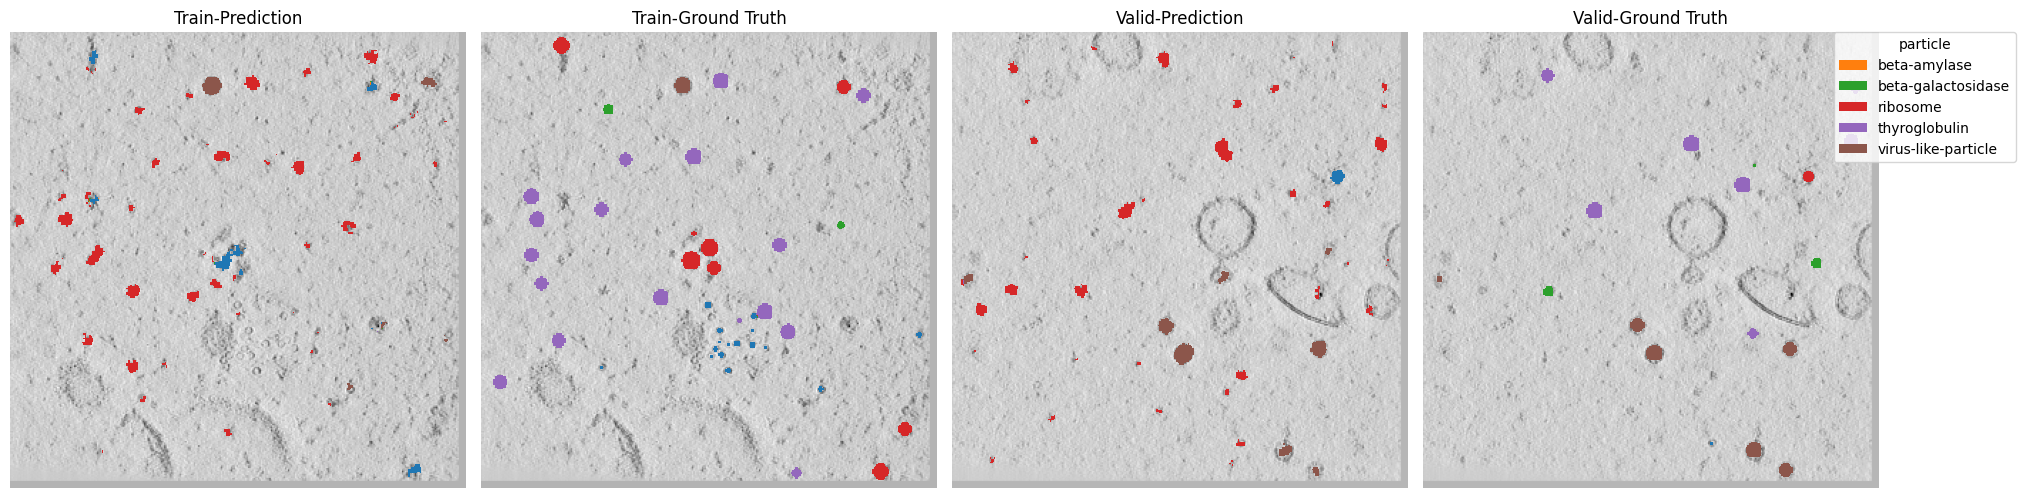

Train-Epoch: 1, Loss: 0.5194311026645744: 100%|██████████| 460/460 [00:53<00:00,  8.54it/s] 
Train-nshuffle-Epoch: 1, Loss: 0.4412280643439811: 100%|██████████| 460/460 [00:19<00:00, 23.51it/s] 


EPOCH: 1, TRAIN_SCORE: 0.002989550690233861


Valid-Epoch: 1, Loss: 0.4680031044003756: 100%|██████████| 184/184 [00:08<00:00, 21.31it/s] 


EPOCH: 1, VALID_SCORE: 0.003871219417706516


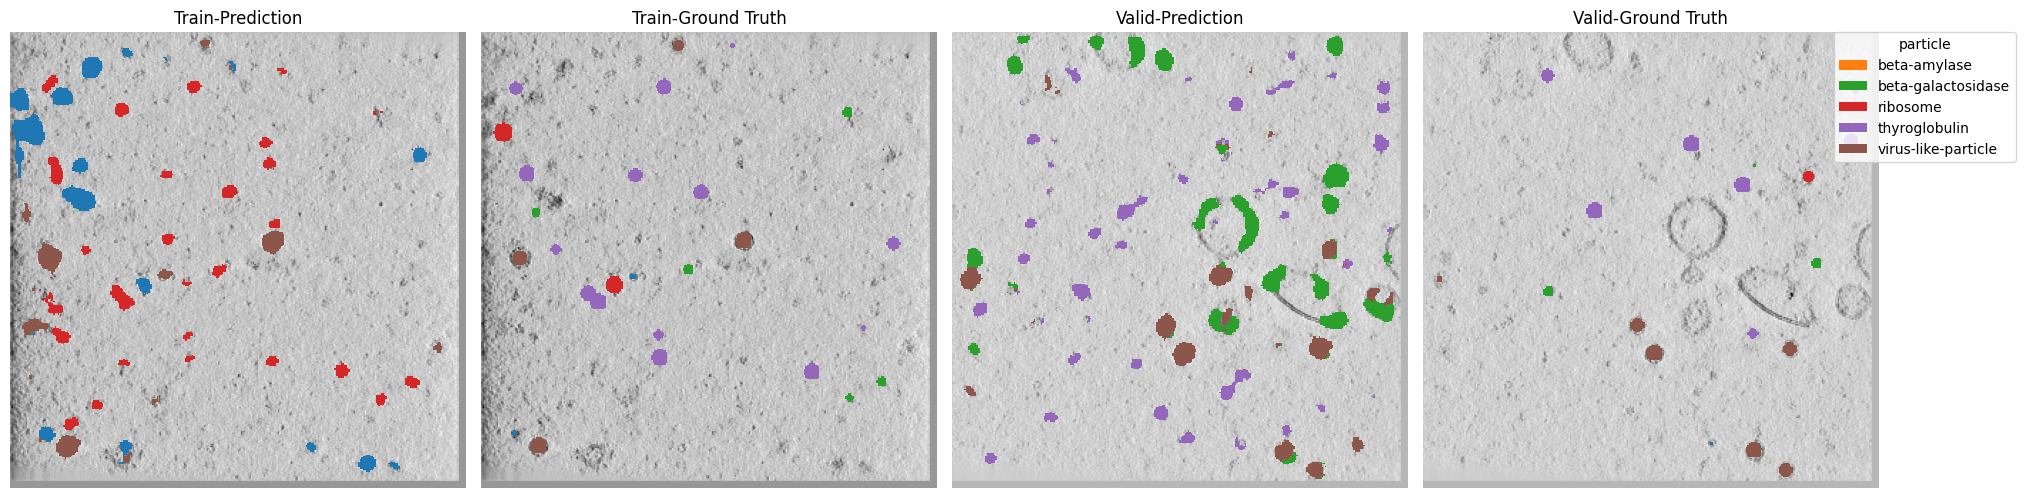

Train-Epoch: 2, Loss: 0.4624855432983326: 100%|██████████| 460/460 [00:53<00:00,  8.58it/s] 
Train-nshuffle-Epoch: 2, Loss: 0.3188426126766464: 100%|██████████| 460/460 [00:20<00:00, 22.22it/s] 


EPOCH: 2, TRAIN_SCORE: 0.0013336918652965637


Valid-Epoch: 2, Loss: 0.3538130604783478: 100%|██████████| 184/184 [00:08<00:00, 22.25it/s] 


EPOCH: 2, VALID_SCORE: 0.0020003405073733107


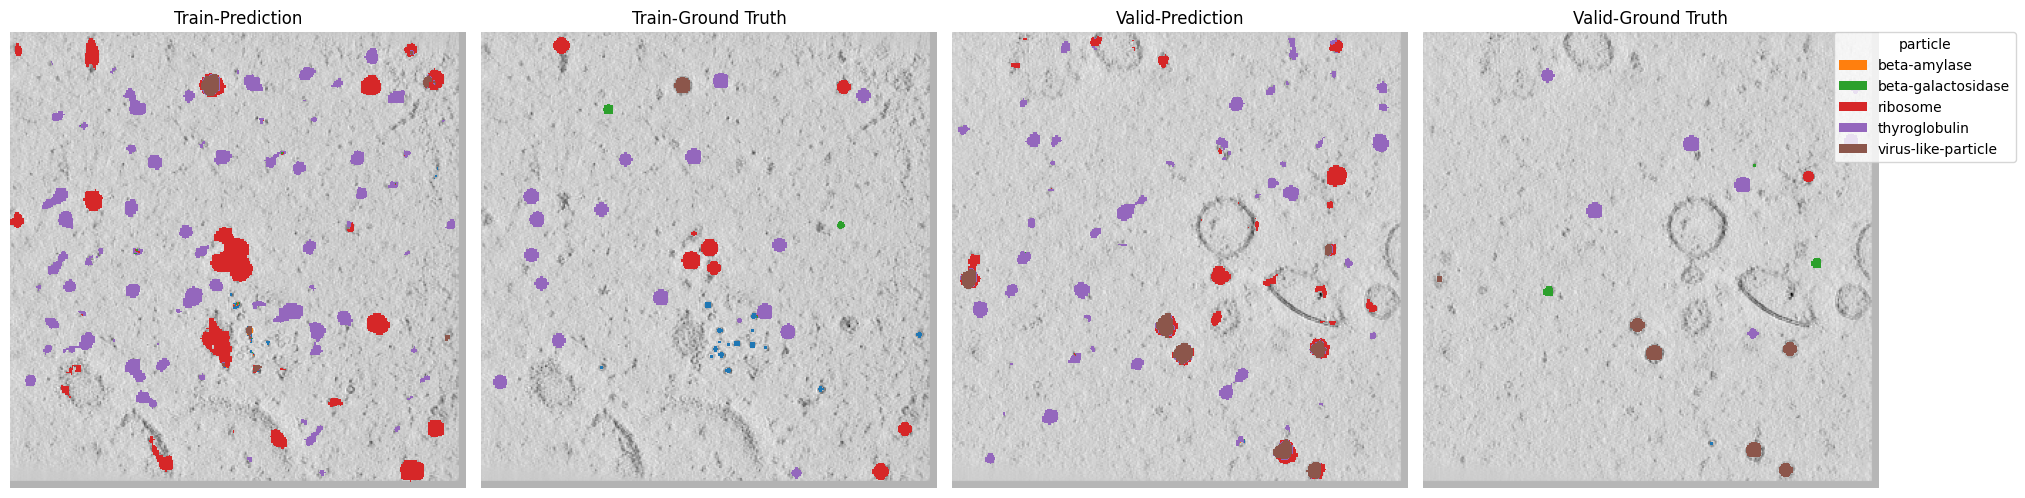

Train-Epoch: 3, Loss: 0.4396836833420979: 100%|██████████| 460/460 [00:55<00:00,  8.35it/s] 
Train-nshuffle-Epoch: 3, Loss: 0.3517466815431481: 100%|██████████| 460/460 [00:20<00:00, 22.87it/s] 


EPOCH: 3, TRAIN_SCORE: 0.003554749338646787


Valid-Epoch: 3, Loss: 0.4402417937982018: 100%|██████████| 184/184 [00:08<00:00, 22.63it/s] 


EPOCH: 3, VALID_SCORE: 0.006214703352658762


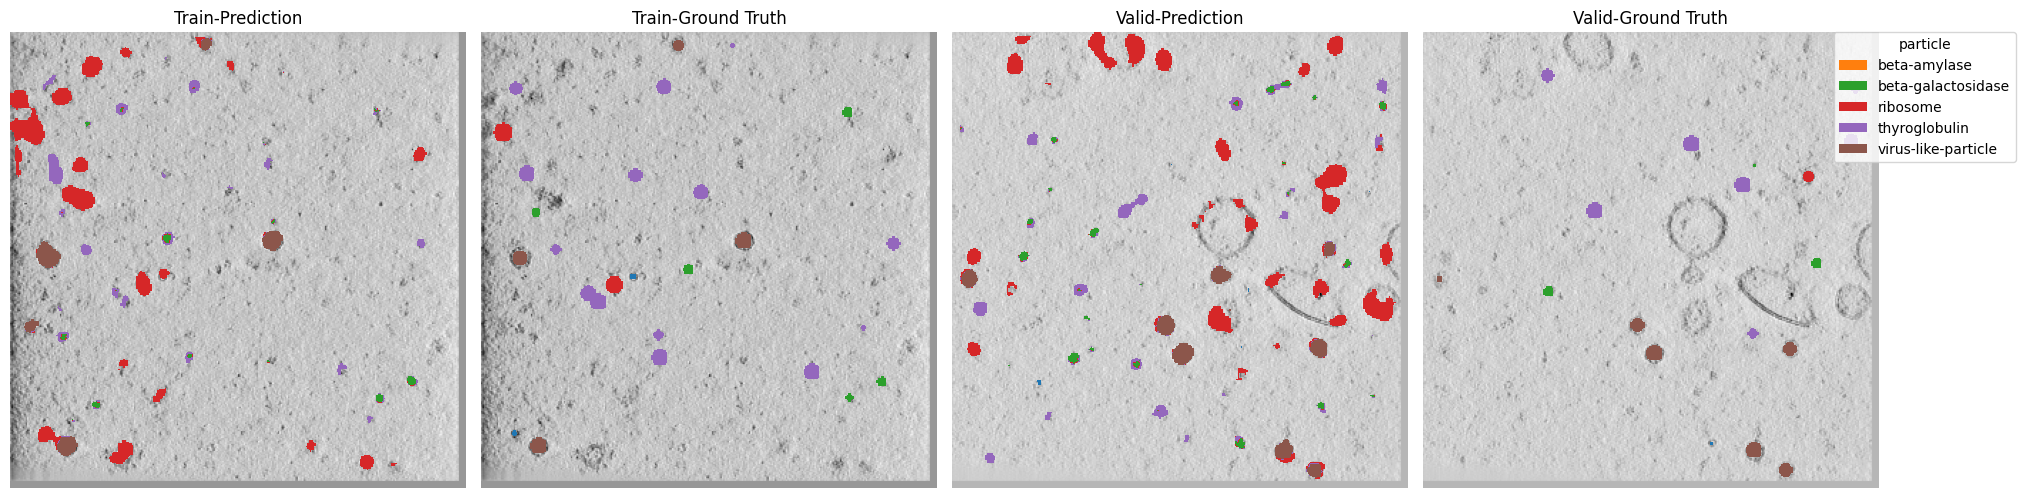

Train-Epoch: 4, Loss: 0.3943061417414118: 100%|██████████| 460/460 [00:55<00:00,  8.32it/s] 
Train-nshuffle-Epoch: 4, Loss: 0.3404718592762947: 100%|██████████| 460/460 [00:20<00:00, 22.49it/s] 


EPOCH: 4, TRAIN_SCORE: 0.003346901383977481


Valid-Epoch: 4, Loss: 0.41281080478802323: 100%|██████████| 184/184 [00:08<00:00, 21.96it/s]


EPOCH: 4, VALID_SCORE: 0.00618395216497705


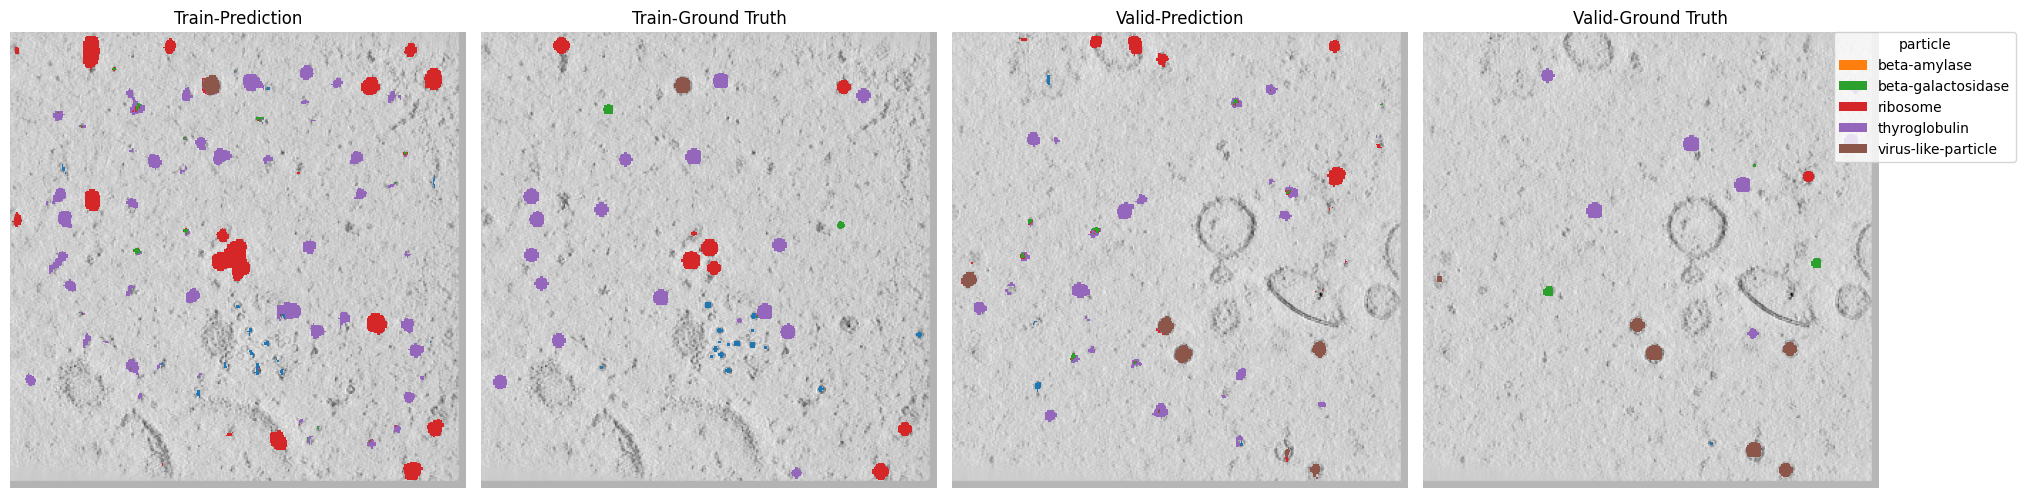

Train-Epoch: 5, Loss: 0.3791929431826524: 100%|██████████| 460/460 [00:54<00:00,  8.46it/s] 
Train-nshuffle-Epoch: 5, Loss: 0.39240885277319215: 100%|██████████| 460/460 [00:19<00:00, 23.09it/s]


EPOCH: 5, TRAIN_SCORE: 0.0031088864973140102


Valid-Epoch: 5, Loss: 0.5134603408286753: 100%|██████████| 184/184 [00:08<00:00, 20.99it/s] 


EPOCH: 5, VALID_SCORE: 0.006681027542942031


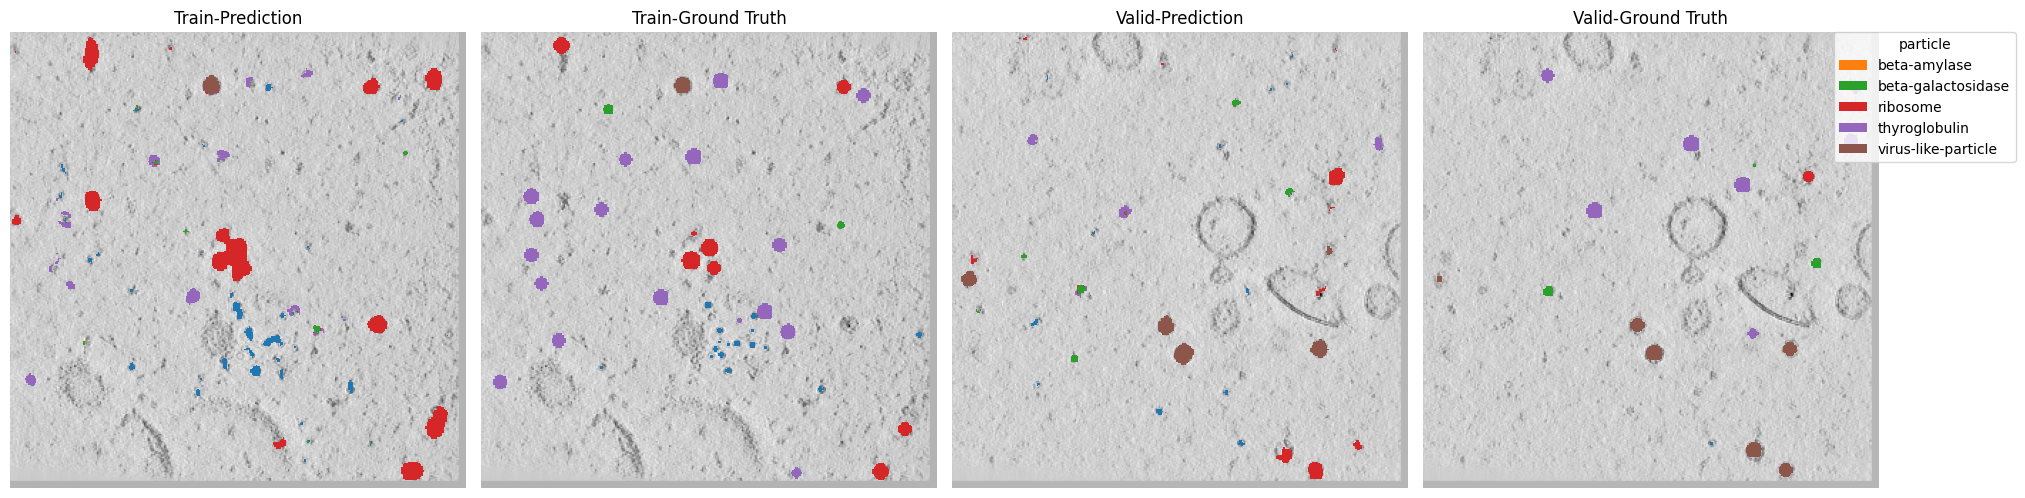

Train-Epoch: 6, Loss: 0.3633366208523512: 100%|██████████| 460/460 [00:55<00:00,  8.33it/s] 
Train-nshuffle-Epoch: 6, Loss: 0.39653648431210414: 100%|██████████| 460/460 [00:20<00:00, 22.29it/s]


EPOCH: 6, TRAIN_SCORE: 0.004205703631303915


Valid-Epoch: 6, Loss: 0.5319377368154086: 100%|██████████| 184/184 [00:07<00:00, 23.23it/s] 


EPOCH: 6, VALID_SCORE: 0.009097497819962538


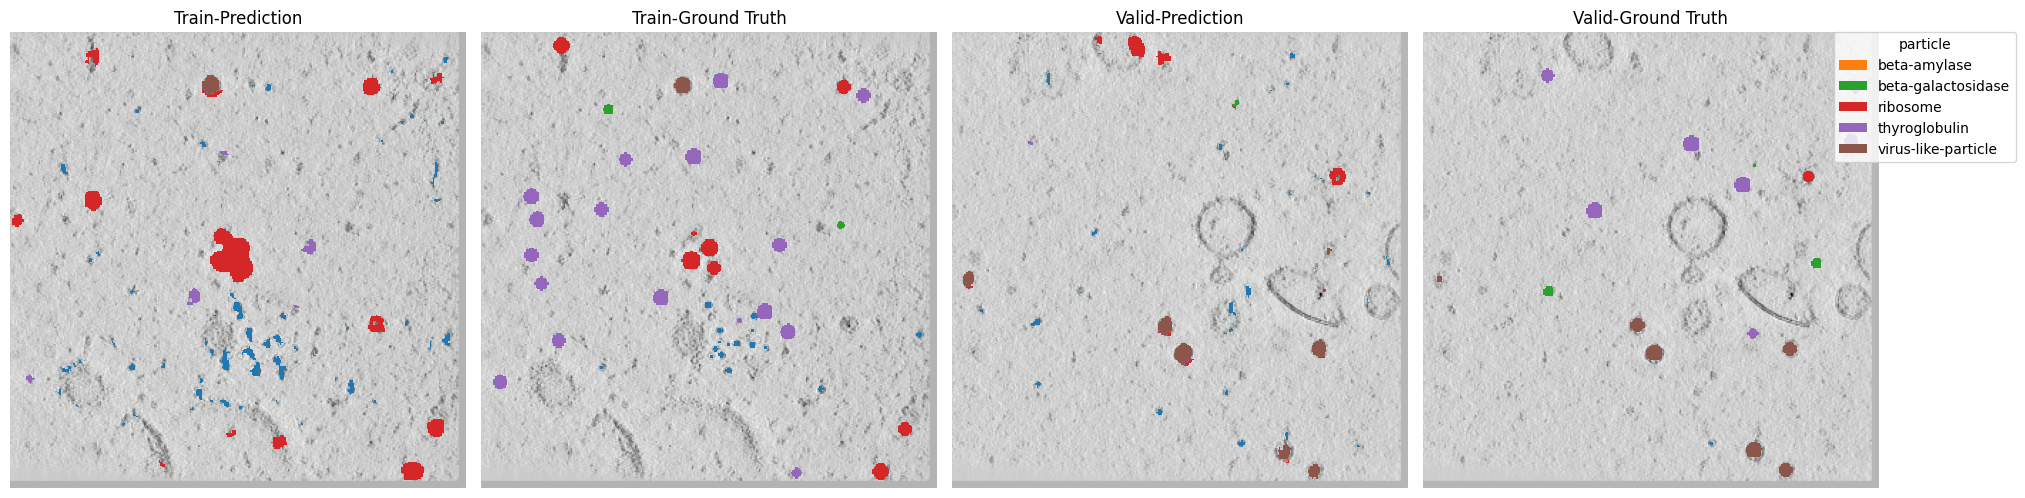

Train-Epoch: 7, Loss: 0.34493747937857455: 100%|██████████| 460/460 [00:55<00:00,  8.36it/s]
Train-nshuffle-Epoch: 7, Loss: 0.32235434630318827: 100%|██████████| 460/460 [00:19<00:00, 23.32it/s]


EPOCH: 7, TRAIN_SCORE: 0.00641932611328674


Valid-Epoch: 7, Loss: 0.4865624030404117: 100%|██████████| 184/184 [00:08<00:00, 20.86it/s] 


EPOCH: 7, VALID_SCORE: 0.004207217729495755


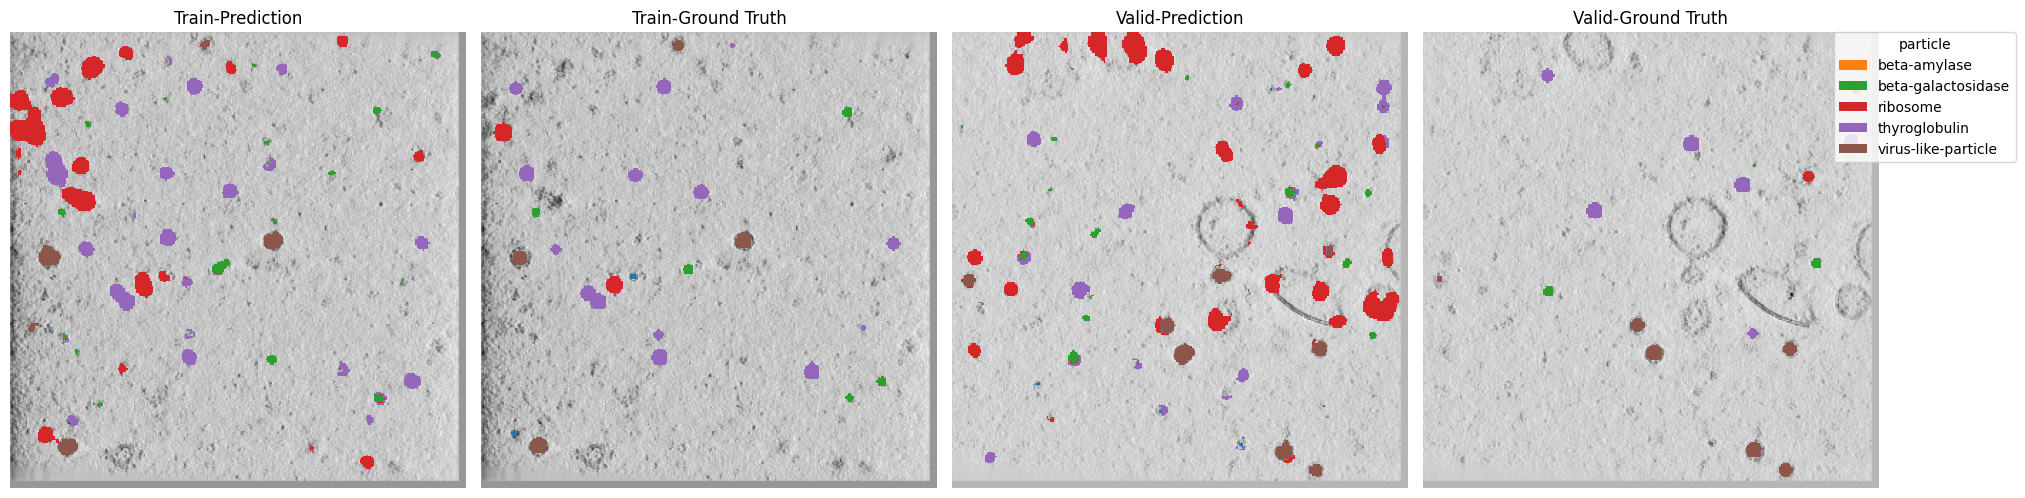

Train-nshuffle-Epoch: 8, Loss: 0.428887894741543: 100%|██████████| 460/460 [00:20<00:00, 22.64it/s]  


EPOCH: 8, TRAIN_SCORE: 0.0038552784659843372


Valid-Epoch: 8, Loss: 0.6589985658293185: 100%|██████████| 184/184 [00:08<00:00, 22.00it/s]


EPOCH: 8, VALID_SCORE: 0.0074164088640130904


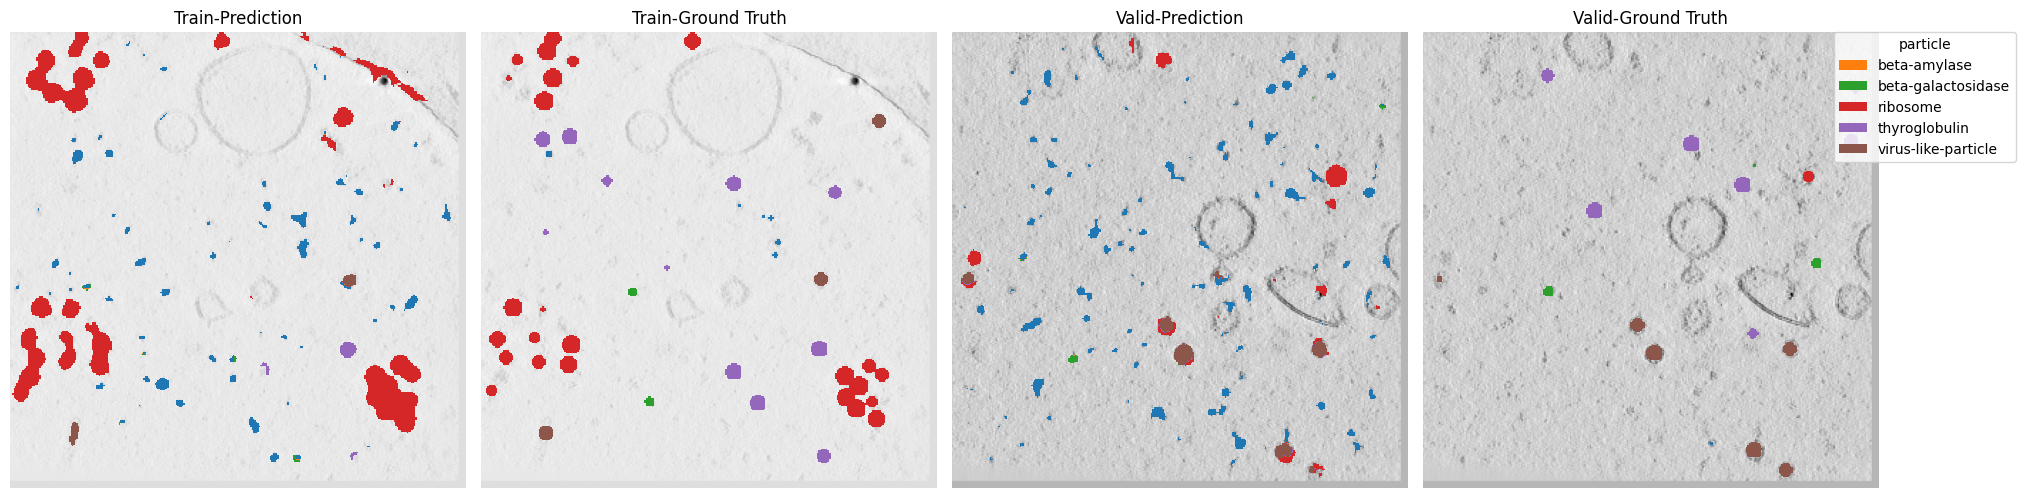

Train-Epoch: 9, Loss: 0.36666071645146153: 100%|██████████| 460/460 [00:54<00:00,  8.41it/s]
Train-nshuffle-Epoch: 9, Loss: 0.3046735652762911: 100%|██████████| 460/460 [00:20<00:00, 22.59it/s] 


EPOCH: 9, TRAIN_SCORE: 0.004181947784005336


Valid-Epoch: 9, Loss: 0.4677422196280373: 100%|██████████| 184/184 [00:08<00:00, 22.92it/s] 


EPOCH: 9, VALID_SCORE: 0.005965332894680754


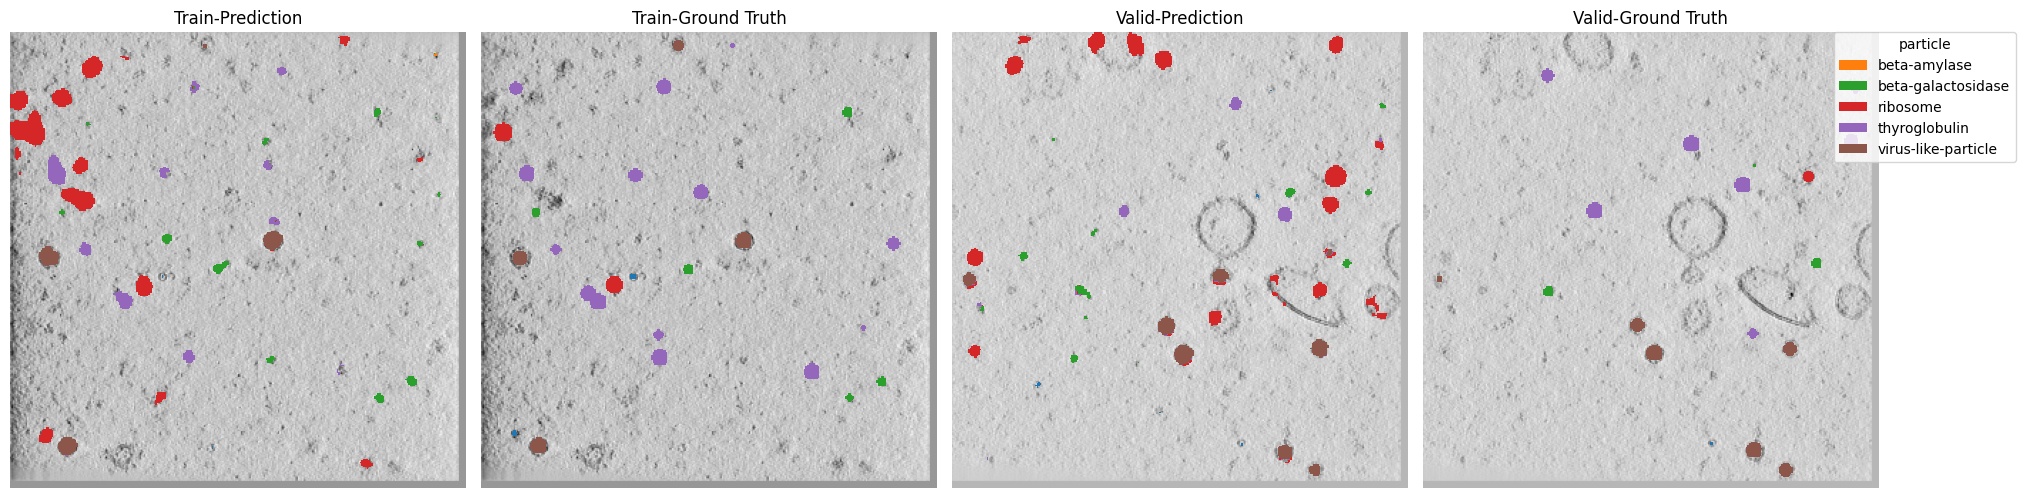

Train-Epoch: 10, Loss: 0.30331080478373107: 100%|██████████| 460/460 [00:55<00:00,  8.25it/s]
Train-nshuffle-Epoch: 10, Loss: 0.4396819199996385:  37%|███▋      | 171/460 [00:07<00:12, 22.78it/s] 

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

best_model = None
best_score = 0
batch_size = 4

for epoch in range(50):
    train_loss = []
    train_nshuffle_loss = []
    valid_loss = []

    train_original_tomogram = defaultdict(list)
    train_pred_tomogram = defaultdict(list)
    train_gt_tomogram = defaultdict(list)

    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0]))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        random_index = torch.randperm(tomogram.shape[1])

        for i in random_index:
            optimizer.zero_grad()
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            input_, gt = aug(input_, gt)
            output = model(input_)
            loss = seg_loss(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    train_exp_name = exp_name

    ######################################## train-nshuffle #########################################
    model.eval()
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_nshuffle_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            train_nshuffle_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_nshuffle_loss)}"
            )
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_nshuffle_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_nshuffle_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_ = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}")

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        valid_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    valid_exp_name = exp_name

    valid_score_ = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )

    print(f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}")

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 描画
    index = 30
    plt.figure(figsize=(20, 5))

    # Train-Pred-Plot
    ax = plt.subplot(1, 4, 1)
    pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred,
        "Train-Prediction",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Train-GT-Plot
    ax = plt.subplot(1, 4, 2)
    gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]
    plot_with_colormap(
        gt,
        "Train-Ground Truth",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Valid-Pred-Plot
    ax = plt.subplot(1, 4, 3)
    pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
    )

    # Valid-GT-Plot
    ax = plt.subplot(1, 4, 4)
    gt = valid_gt_tomogram[valid_exp_name][index][0]
    plot_with_colormap(
        gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
    )

    # 凡例を追加
    legend_elements = [
        Patch(facecolor=colors[i], label=CFG.particles_name[i])
        for i in range(1, num_classes)
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper right",
        title="particle",
        bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
        borderaxespad=0,
    )

    plt.tight_layout()
    plt.show()

# save_images(
#     train_gt_tomogram=train_gt_tomogram,
#     train_pred_tomogram=train_pred_tomogram,
#     valid_gt_tomogram=valid_gt_tomogram,
#     valid_pred_tomogram=valid_pred_tomogram,
#     save_dir="images",
#     epoch=epoch,
# )

In [ ]:
list(random_indices.detach().numpy())